# Skip-gram Word2Vec with Negative Sampling

In [1]:
import re
from collections import Counter
import collections
import random
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import math
import os
import json, csv
from math import acos
from scipy.stats import spearmanr
from torch import linalg as LA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from statistics import variance
from statistics import mean

from random import *
import random

---
## 1. Load Data

Load [text8 dataset](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip), a file of cleaned up ***Wikipedia articles*** by Matt Mahoney 

In [2]:
from google.colab import drive, files
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Experiments/SGNSv2-Check
!ls

device = 'cuda' if torch.cuda.is_available else 'cpu'

Mounted at /content/drive
/content/drive/MyDrive/Experiments/SGNSv2-Check
text8


In [3]:
with open('text8') as f:
    text = f.read()

print(text[:100])  # first 100 characters

 anarchism originated as a term of abuse first used against early working class radicals including t


# 2. Pre-process text

* Convert any punctuation into tokens, e.g. a period is changed to ` <PERIOD> `. (Note: `text8` dataset doesn't contain any periods.)
* Remove all words that show up ≤5 times in the dataset to
  * reduce issues due to noise in the data 
  * improve the quality of the vector representations
* Return a list of preprocessed words in the text

In [4]:
import re
from collections import Counter

def preprocess(text):

    # Convert all text to lowercase
    text = text.lower()

    # Replace punctuation with tokens so we can use them in our model
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with 5 or less occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    # ADDED FROM GALVAN
    # remove common words that do not provide much meaning to the text
    stop = ['also', 'four', 'seven', 'six', 'three', 'five', 'eight', 'zero', 'two', 'nine', 'one', 'herself', 'any',
            'should', 'of', "you'll", 'out', 'yours', 'once', 'between', 'again', 'theirs', 'over', 'didn', 'whom',
            "she's", 'm', 'now', 'y', 'that', "you're", 'more', "doesn't", 'myself', 't', "won't", 'the', 'after',
            'haven', 'in', 'hasn', "couldn't", 'this', 'up', 'if', "shouldn't", 'yourselves', 'while', 'before', 'off',
            "don't", 'mightn', 'ma', 'these', 'both', 'very', 'weren', 'we', 'don', 'doesn', 'be', 'themselves', 'all',
            "hasn't", 'can', "wasn't", 'them', 'ours', "aren't", 'she', 'have', "shan't", "mightn't", 'nor', 'each',
            "you've", 'was', 'having', 'your', 'about', 'where', 'shouldn', 'a', 'couldn', "didn't", "that'll", 'down',
            'is', 'such', 'by', 'ain', 'isn', 'himself', 'so', 'his', 'an', 'but', 's', 'wasn', 'against', 'shan',
            'how', 'our', 'yourself', 'am', 'who', 'won', 'at', "needn't", 'through', 'are', 'or', 'too', 'he', 'what',
            'for', 'most', 'will', 'then', 'and', 'until', 'hadn', 'they', 've', 'just', "wouldn't", 'some', "hadn't",
            'been', 'to', 'into', 'its', 'do', 'aren', 'hers', 'as', 'her', 'needn', 'further', 'with', 'own',
            "haven't", 'o', 'd', 'why', 'here', "mustn't", 'during', 'below', 'on', 'from', 'when', 're', "you'd",
            "it's", 'than', 'under', 'wouldn', 'did', 'because', 'itself', 'me', 'no', 'only', 'does', 'being', 'were',
            'those', "isn't", 'has', 'him', 'i', 'same', 'mustn', 'above', 'it', 'which', 'had', 'other', 'there',
            'ourselves', 'll', 'you', 'few', 'their', 'doing', "weren't", 'not', "should've", 'my']
    trimmed_words = [i for i in trimmed_words if i not in stop]

    return trimmed_words

In [5]:
# get vocabulary 
words = preprocess(text)
print(text[:100])
print(words[:30])

 anarchism originated as a term of abuse first used against early working class radicals including t
['anarchism', 'originated', 'term', 'abuse', 'first', 'used', 'early', 'working', 'class', 'radicals', 'including', 'diggers', 'english', 'revolution', 'sans', 'culottes', 'french', 'revolution', 'whilst', 'term', 'still', 'used', 'pejorative', 'way', 'describe', 'act', 'used', 'violent', 'means', 'destroy']


In [6]:
print("Total # of words: {}".format(len(words)))
print("# of unique words: {}".format(len(set(words)))) 

Total # of words: 8736003
# of unique words: 63480


# 3. Create Dictionaries

Sorted in descending frequency order (e.g. most frequent word `"the"` is assigned as `0`).


In [7]:
def create_lookup_tables(words):
  
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True) # descending freq order
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

In [8]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]
print(vocab_to_int)

{'first': 0, 'many': 1, 'new': 2, 'used': 3, 'american': 4, 'time': 5, 'see': 6, 'may': 7, 'world': 8, 'b': 9, 'would': 10, 'however': 11, 'years': 12, 'states': 13, 'people': 14, 'war': 15, 'united': 16, 'known': 17, 'called': 18, 'use': 19, 'th': 20, 'system': 21, 'often': 22, 'state': 23, 'history': 24, 'city': 25, 'english': 26, 'made': 27, 'well': 28, 'e': 29, 'number': 30, 'government': 31, 'later': 32, 'since': 33, 'part': 34, 'name': 35, 'c': 36, 'century': 37, 'x': 38, 'university': 39, 'early': 40, 'life': 41, 'british': 42, 'year': 43, 'like': 44, 'including': 45, 'became': 46, 'example': 47, 'day': 48, 'even': 49, 'work': 50, 'language': 51, 'although': 52, 'several': 53, 'form': 54, 'john': 55, 'u': 56, 'national': 57, 'much': 58, 'g': 59, 'french': 60, 'general': 61, 'n': 62, 'high': 63, 'links': 64, 'could': 65, 'based': 66, 'second': 67, 'de': 68, 'music': 69, 'another': 70, 'large': 71, 'f': 72, 'external': 73, 'german': 74, 'different': 75, 'modern': 76, 'great': 77, 

# 4. Perform Word Subsampling

In [9]:
def subsample_words(int_words, threshold = 1e-5):
  word_counts = Counter(int_words)
  total_n_words = len(int_words)

  freq_ratios = {word: count/total_n_words for word, count in word_counts.items()}
  p_drop = {word: 1 - np.sqrt(threshold/freq_ratios[word]) for word in word_counts}

  return [word for word in int_words if random.random() < (1 - p_drop[word])]

In [10]:
  train_words = subsample_words(int_words)
  print(len(int_words))
  print(len(train_words))
  print(len(train_words)/len(int_words))

8736003
3493341
0.3998786401515659


# 5. Generate Context Targets

In [11]:
import random
def get_target(words, idx, max_window_size=5):
    R = np.random.randint(3, max_window_size + 1)
    start = max(0,idx-R)
    end = min(idx+R,len(words)-1)
    targets = words[start:idx] + words[idx+1:end+1] # +1 since doesn't include this idx
    return targets

# 6. Generate Batches 

In [12]:
def get_batches(words, batch_size, max_window_size=5):
  # only full batches
  n_batches = len(words)//batch_size
  words = words[:n_batches*batch_size]
  for i in range(0, len(words), batch_size):
    batch_of_center_words = words[i:i+batch_size]   # current batch of words
    batch_x, batch_y = [], []  

    for ii in range(len(batch_of_center_words)):  # range(batch_size) unless truncated at the end
      x = [batch_of_center_words[ii]]             # single word
      y = get_target(words=batch_of_center_words, idx=ii, max_window_size=max_window_size)  # list of context words

      batch_x.extend(x * len(y)) # repeat the center word (n_context_words) times
      batch_y.extend(y)
  
    yield batch_x, batch_y       # ex) [1,1,2,2,2,2,3,3,3,3], [0,2,0,1,3,4,1,2,4,5]

# 12. Train!

In [13]:
def forward_noise(batch_size, n_samples=5):
  """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
  # As defined in the paper by Mikolov et all.
  freq = Counter(int_words)
  freq_ratio = {word:cnt/len(vocab_to_int) for word, cnt in freq.items()}        
  freq_ratio = np.array(sorted(freq_ratio.values(), reverse=True))
  unigram_dist = freq_ratio / freq_ratio.sum() 
  noise_dist = torch.from_numpy(unigram_dist**0.75 / np.sum(unigram_dist**0.75))
      
  noise_words = torch.multinomial(input       = noise_dist,           # input tensor containing probabilities
                                  num_samples = batch_size * n_samples, # number of samples to draw
                                  replacement = True)
  
  noise_words = noise_words.view(-1, 5)
  
  noise_words = noise_words.detach().tolist()


  
  return noise_words

In [14]:
def cosine_similarity(v1, v2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(v1)):
        x = v1[i];
        y = v2[i]
        sumxx += x * x
        sumyy += y * y
        sumxy += x * y
    return sumxy / math.sqrt(sumxx * sumyy)

In [15]:
import gensim.downloader as api

word_to_embeddings = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [16]:
def log_samples(input_words, target_words, noise_words):
  with open('log_samples.txt', 'a') as f:
    f.write("\n\n-- POSITIVE SAMPLES --\n")
    for idx, input_word in enumerate(input_words):
      if idx % 5 == 0:
        f.write(int_to_vocab[input_word] + " : " + int_to_vocab[target_words[idx]] + "\n")

    f.write("\n\n-- NEGATIVE SAMPLES --\n")
    for idx, input_word in enumerate(input_words):
      f.write(int_to_vocab[input_word] + " : " + int_to_vocab[noise_words[idx][2]] + "\n")

  print("Logged successfully.")

In [17]:
def print_progress_bar(current_batch, number_of_batches, cutoff = 1.0, bar_length=50):
    progress = float(current_batch) / number_of_batches
    arrow = '=' * int(round(progress * bar_length)-1)
    spaces = '-' * (bar_length - len(arrow))

    print('\rBatches: [%s%s] %d %%' % (arrow, spaces, int(round(progress * 100))), end='')

    return (progress >= cutoff)

In [18]:
target_to_input = []
noise_to_input = []

batch_size = 512
n_negative_samples = 5
#log_every = 100
calc_every = 5
cutoff = 10.0 / 100.0

batch = 0

n_batches = len(train_words) // batch_size
print("Number of bathces to generate: ", n_batches)
print("Will cut off at: ", int(n_batches * cutoff), "\n")

for inputs, targets in get_batches(train_words, batch_size=batch_size):

  #if len(target_to_input) >= 200000:
  #  break
  
  batch += 1
  
  inputs_tensor = torch.LongTensor(inputs)#.to(device)    # [b*n_context_words]
  
  noise_words = forward_noise(batch_size=inputs_tensor.shape[0], 
                                              n_samples=n_negative_samples)
  
  for idx, in_word in enumerate(inputs):

    if idx % calc_every == 1:

      try:

        input_word_str = int_to_vocab[in_word]
        target_str = int_to_vocab[targets[idx]]
        noise_str = [ int_to_vocab[n_w] for n_w in noise_words[idx] ]

        input_word = word_to_embeddings[input_word_str]
        target1 = word_to_embeddings[target_str]
        noise = [ word_to_embeddings[n_w] for n_w in noise_str ]

        target_to_input.append( cosine_similarity( target1 , input_word ) )
        noise_to_input.extend( [cosine_similarity( n_w , input_word ) for n_w in noise] )

      except (KeyError):

        continue

  if print_progress_bar(batch, n_batches, cutoff):
    break        

  #if batch % log_every == 1:
  #  print("Samples: ", len(target_to_input))
  #  log_samples(inputs, targets, noise_words)

  

Number of bathces to generate:  6822
Will cut off at:  682 

Batches: [====----------------------------------------------] 10 %

In [19]:
print(len(target_to_input))
print(len(noise_to_input))

258146
1290730


In [20]:
print("Average similarity of each target-input pair: " , mean(target_to_input))
print("Average similarity of each noise-input pair: " , mean(noise_to_input))

Average similarity of each target-input pair:  0.14041648822065442
Average similarity of each noise-input pair:  0.0672248311512843


In [21]:
print("Variance of cos similarity of each target-input pair: " , variance(target_to_input))
print("Variance of cos similarity of each noise-input pair: " , variance(noise_to_input))

Variance of cos similarity of each target-input pair:  0.030020507083719988
Variance of cos similarity of each noise-input pair:  0.0070645914466351675


In [22]:
smp_noise_to_input = [x for idx, x in enumerate(noise_to_input) if (idx % 5 == 0)]

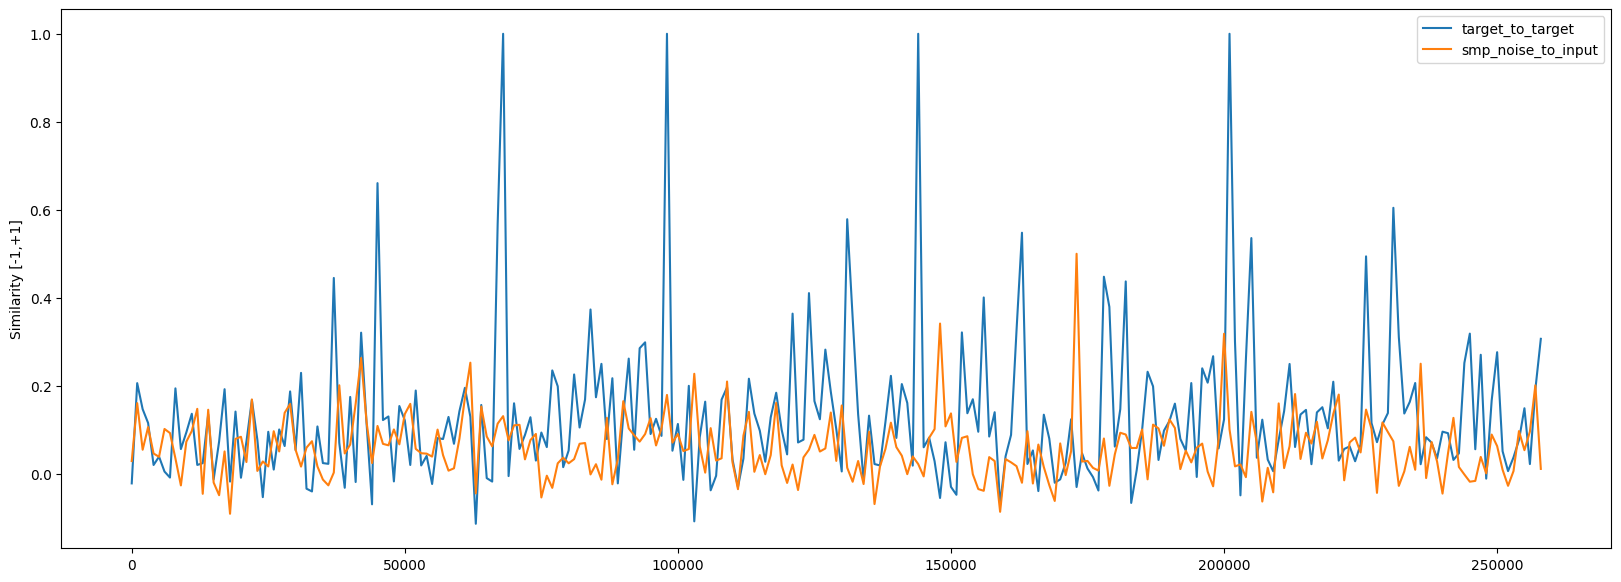

In [24]:
sample_step = 1000

plt.figure(figsize=(20,7))

line1 = [(idx, x) for idx, x in enumerate(target_to_input) if (idx % sample_step==0)]
line2 = [(idx, x) for idx, x in enumerate(smp_noise_to_input) if (idx % sample_step==0)]

plt.plot([x[0] for x in line1], [x[1] for x in line1], label = "target_to_target")
plt.plot([x[0] for x in line2], [x[1] for x in line2], label = "smp_noise_to_input")

plt.ylabel("Similarity [-1,+1]")
plt.legend()
plt.show()